In [4]:
# Реализуйте высокочастотную фильтрацию на основе ядра Гаусса
# Реализуйте удаление периодического шума

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

image = cv.imread('periodic_noise.jpg')
image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

1. Высокочастотная фильтрация на основе ядра Гаусса

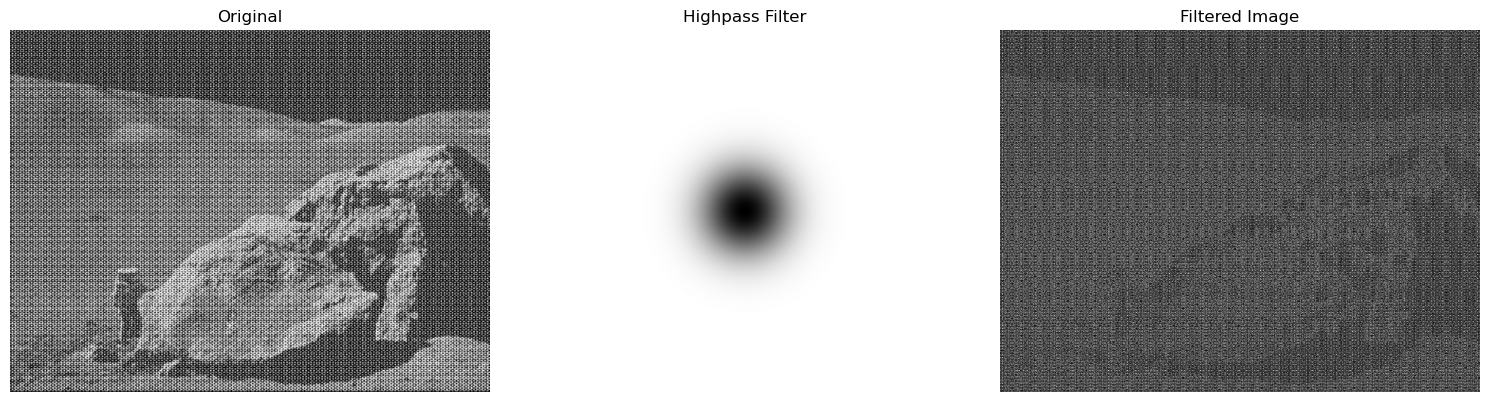

In [2]:
def gaussian_highpass_filter(image, sigma=50):
    dft_shift = np.fft.fftshift(cv.dft(np.float32(image), flags=cv.DFT_COMPLEX_OUTPUT))
    rows, cols = image.shape
    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - cols // 2) ** 2 + (y - rows // 2) ** 2)
    gauss_highpass = 1 - np.exp(-(distance ** 2) / (2 * sigma ** 2))
    mask = np.dstack([gauss_highpass] * 2)
    img_back = cv.idft(np.fft.ifftshift(dft_shift * mask))
    img_back = cv.normalize(cv.magnitude(img_back[:, :, 0], img_back[:, :, 1]), None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    
    return img_back, gauss_highpass
highpass_img, gaussian_mask = gaussian_highpass_filter(image_gray)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(image_gray, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(gaussian_mask, cmap='gray'); plt.title('Highpass Filter'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(highpass_img, cmap='gray'); plt.title('Filtered Image'); plt.axis('off')
plt.tight_layout()
plt.show()

2. Удаление периодического шума

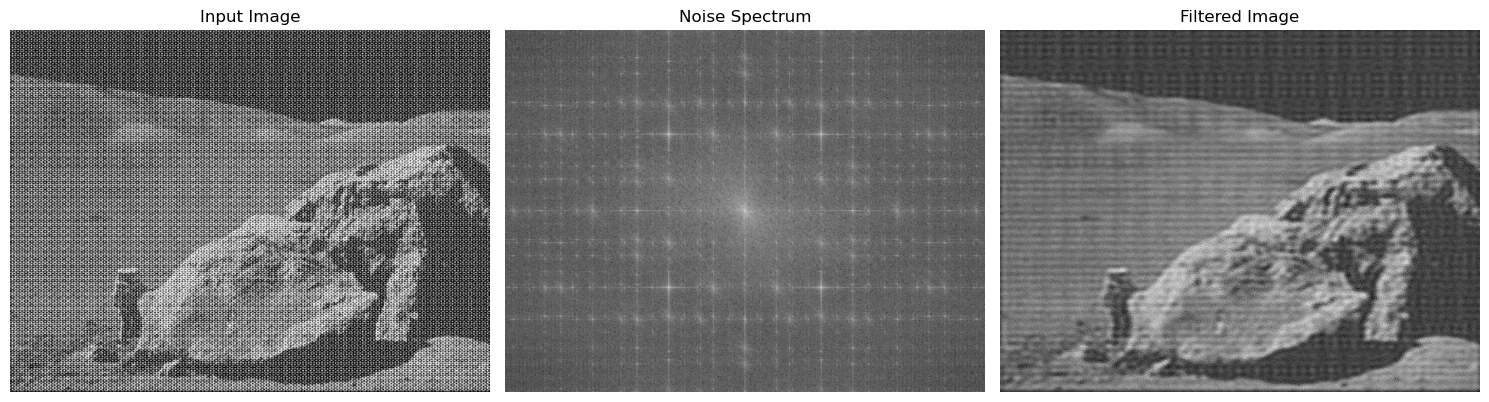

In [3]:

def remove_periodic_noise(img):
    dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude = 20 * np.log(cv.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
    
    threshold = np.percentile(magnitude, 85)  # Подбираем по процентилям для исключения шума
    noise_mask = magnitude > threshold
    
    rows, cols = img.shape
    center_y, center_x = rows // 2, cols // 2
    center_radius = min(rows, cols) // 10
    
    filter_mask = np.ones((rows, cols, 2), np.float32)
    for y in range(rows):
        for x in range(cols):
            if noise_mask[y, x]:
                dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
                if dist > center_radius:
                    filter_mask[y, x] = 0
                    filter_mask[rows - 1 - y, cols - 1 - x] = 0
    
    fshift = dft_shift * filter_mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv.idft(f_ishift)
    
    img_back = cv.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    denoised_image = cv.normalize(img_back, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    
    return denoised_image, magnitude

denoised_image, magnitude = remove_periodic_noise(image_gray)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(image_gray, cmap='gray'); plt.title('Input Image'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(magnitude, cmap='gray'); plt.title('Noise Spectrum'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(denoised_image, cmap='gray'); plt.title('Filtered Image'); plt.axis('off')
plt.tight_layout()
plt.show()